In [ ]:
import StringIO

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import google.datalab.bigquery as bq

import tensorflow as tf

In [ ]:
nikkei = bq.Query.from_table(bq.Table('bingo-ml-1.market_data.nikkei'), fields=['Date', 'Close']).execute().result().to_dataframe().set_index('Date')
ftse = bq.Query.from_table(bq.Table('bingo-ml-1.market_data.ftse'), fields=['Date', 'Close']).execute().result().to_dataframe().set_index('Date')

In [ ]:
closing_data = pd.DataFrame()

closing_data['nikkei_close'] = nikkei['Close']
closing_data['ftse_close'] = ftse['Close']

closing_data = closing_data.fillna(method = 'ffill')

In [ ]:
closing_data.describe()
closing_data = closing_data.sort_index()
closing_data.describe()

In [ ]:
_ = pd.concat([closing_data['nikkei_close'],closing_data['ftse_close']],axis = 1).plot(figsize=(18,8))

In [ ]:
# Portfolio definition

len_series = len(nikkei)

def price_vector(time_lag, t):
  return closing_data[t-time_lag:t]

def current_price_nikkei(t):
  return closing_data['nikkei_close'][t]

def current_price_ftse(t):
  return closing_data['ftse_close'][t]

def portfolio_value(portfolio_shares, t):
  prices = [current_price_nikkei(t), current_price_ftse(t)]
  return np.inner(portfolio_shares,prices);

def alpha_fun(shares,t):
  alpha = shares[0]*current_price_nikkei(t)/portfolio_value(shares,t)
  return alpha

In [ ]:
# Buy and Hold strategy [Nikkei only]

initial_endowment = current_price_nikkei(0)
investment_percentage = 1;
amount_invested = initial_endowment * investment_percentage

# Nikkei only - invest all

nikkei_0 =amount_invested/current_price_nikkei(0)
ftse_0 = 0
shares_0 = [nikkei_0, ftse_0]
value_0 = portfolio_value(shares_0,0)
alpha_0 = alpha_fun(shares_0,0)
cash_0 = initial_endowment - amount_invested

state_nikkei = pd.DataFrame()

state_nikkei['price_nikkei'] = np.zeros(len_series)
state_nikkei['price_ftse'] = np.zeros(len_series)
state_nikkei['portfolio_shares_nikkei'] = np.zeros(len_series)
state_nikkei['portfolio_shares_ftse'] = np.zeros(len_series)
state_nikkei['value'] = np.zeros(len_series)
state_nikkei['alpha'] = np.ones(len_series)
state_nikkei['cash'] = np.zeros(len_series)

state_nikkei['price_nikkei'][0] = current_price_nikkei(0)
state_nikkei['price_ftse'][0] = current_price_ftse(0)
state_nikkei['portfolio_shares_nikkei'] = shares_0[0] * np.ones(len_series)
state_nikkei['portfolio_shares_ftse'] = shares_0[1] *np.ones(len_series)
state_nikkei['value'][0] = value_0

for time in range(len_series):
  state_nikkei['price_nikkei'][time] = current_price_nikkei(time)
  state_nikkei['price_ftse'][time] = current_price_ftse(time)
  state_nikkei['value'][time] = portfolio_value(shares_0,time)


In [ ]:
# Buy and Hold strategy [Ftse only]

initial_endowment = current_price_nikkei(0)
investment_percentage = 1;
amount_invested = initial_endowment*investment_percentage

# Ftse only - invest all

nikkei_0 =0
ftse_0 = amount_invested/current_price_ftse(0)
shares_0 = [nikkei_0, ftse_0]
value_0 = portfolio_value(shares_0,0)
alpha_0 = alpha_fun(shares_0,0)
cash_0 = initial_endowment - amount_invested

state_ftse = pd.DataFrame()

state_ftse['price_nikkei'] = np.zeros(len_series)
state_ftse['price_ftse'] = np.zeros(len_series)
state_ftse['portfolio_shares_nikkei'] = np.zeros(len_series)
state_ftse['portfolio_shares_ftse'] = np.zeros(len_series)
state_ftse['value'] = np.zeros(len_series)
state_ftse['alpha'] = np.ones(len_series)
state_ftse['cash'] = np.zeros(len_series)

state_ftse['price_nikkei'][0] = current_price_nikkei(0)
state_ftse['price_ftse'][0] = current_price_ftse(0)
state_ftse['portfolio_shares_nikkei'] = shares_0[0] * np.ones(len_series)
state_ftse['portfolio_shares_ftse'] = shares_0[1] *np.ones(len_series)
state_ftse['value'][0] = value_0

for time in range(len_series):
    state_ftse['price_nikkei'][time] = current_price_nikkei(time)
    state_ftse['price_ftse'][time] = current_price_ftse(time)
    state_ftse['value'][time] = portfolio_value(shares_0,time)

In [ ]:
# buy and hold [alpha = .5]
investment_percentage = 1;
amount_invested = initial_endowment*investment_percentage

nikkei_0 = amount_invested/(2*current_price_nikkei(0))
ftse_0 = nikkei_0*current_price_nikkei(0)/current_price_ftse(0)
shares_0 = [nikkei_0, ftse_0]
value_0 = portfolio_value(shares_0,0)
alpha_0 = alpha_fun(shares_0,0)
cash_0 = initial_endowment - amount_invested

state_bh = pd.DataFrame()

state_bh['price_nikkei'] = np.zeros(len_series)
state_bh['price_ftse'] = np.zeros(len_series)
state_bh['portfolio_shares_nikkei'] = nikkei_0*np.ones(len_series)
state_bh['portfolio_shares_ftse'] = ftse_0*np.ones(len_series)
state_bh['value'] = np.zeros(len_series)
state_bh['alpha'] = np.zeros(len_series)
state_bh['cash'] = np.zeros(len_series)

for time in range(len_series):
  state_bh['price_nikkei'][time] = current_price_nikkei(time)
  state_bh['price_ftse'][time] = current_price_ftse(time)
  state_bh['value'][time] = portfolio_value(shares_0,time)
  state_bh['alpha'][time] = alpha_fun(shares_0,time)
  state_bh['cash'][time] = cash_0

#state_bh['value'].plot(figsize=(18,8))


_ = pd.concat([state_nikkei['value'],state_ftse['value']],axis = 1).plot(figsize=(18,8))

_ = pd.concat([state_nikkei['value'],state_ftse['value'],state_bh['value']],axis = 1).plot(figsize=(18,8))


In [61]:
# RL Algo

# Reward function

def reward_function(portfolio_value,time):
  return portfolio_value(time) - portfolio_value(time-1)

def new_shares(previous_shares, action, time):
  prev_shares_instrument_0 =  previous_shares[0]
  prev_shares_instrument_1 = previous_shares[1]
  
  prev_price_instrument_0 = current_price_nikkei(time-1)
  prev_price_instrument_1 = current_price_ftse(time-1)
  
  prev_portfolio_value = portfolio_value(previous_shares, time-1)
  
  new_shares_instrument_0 = prev_shares_instrument_0 + action * prev_portfolio_value / prev_price_instrument_0
  new_shares_instrument_1 = prev_shares_instrument_1 - action * prev_portfolio_value / prev_price_instrument_1

  return [new_shares_instrument_0, new_shares_instrument_1]

def valid_actions(current_shares,time):
  action_range = [-.3,-.2,-.1, 0 , .1, .2, .3]
  valid_actions_list = [];
  for action in action_range:
    x_0 = new_shares(current_shares, action,time)[0]
    x_1 = new_shares(current_shares, action,time)[1]
    # print x_0,x_1
    if(x_0>0 and x_1>0):
      valid_actions_list.append(action)
  return valid_actions_list

In [72]:
# Rebalance portfolio by buying buying and selling stocks so to move action% of current value from asset 0 to asset 1

def rebalanced_value(action, current_shares, lag, transaction_cost, time):
    rebalanced_shares = new_shares(current_shares, action, time+1)
    new_value = 0;
    for l in range(lag):
        new_value += portfolio_value(rebalanced_shares, time-l)
    rebalanced_value = new_value/lag - transaction_cost ### make it depend on number of stocks traded
    return rebalanced_value

  
# Make greedy action according to the value that portfolio would have had if its composition would have differred by moving action% of current value from asset 0 to asset 1
def greedy_action(current_shares, lag, transaction_cost, time):
    actions = valid_actions(current_shares, time);
    greedy_guess = portfolio_value(current_shares, time)
    greedy_action = 0;
    for action in actions:
        value_action = rebalanced_value(action, current_shares, lag, transaction_cost, time)
        if value_action>greedy_guess:
            greedy_action = action
    return greedy_action

In [104]:
# The greedy investor: initialize portfolio at balanced alpha and be greedy

investment_percentage = 1;
amount_invested = initial_endowment*investment_percentage
lag = 10
nikkei_0 = amount_invested/(2*current_price_nikkei(0))
ftse_0 = nikkei_0*current_price_nikkei(0)/current_price_ftse(0)
shares_0 = [nikkei_0, ftse_0]
value_0 = portfolio_value(shares_0,0)
alpha_0 = alpha_fun(shares_0,0)
cash_0 = initial_endowment - amount_invested
transaction_cost = .01;
state_greedy = pd.DataFrame()

state_greedy['price_nikkei'] = np.zeros(len_series)
state_greedy['price_ftse'] = np.zeros(len_series)
state_greedy['portfolio_shares_nikkei'] = nikkei_0*np.ones(len_series)
state_greedy['portfolio_shares_ftse'] = ftse_0*np.ones(len_series)
state_greedy['value'] = np.zeros(len_series)
state_greedy['alpha'] = np.zeros(len_series)
state_greedy['cash'] = np.zeros(len_series)

current_shares = list([state_greedy['portfolio_shares_nikkei'][0], state_greedy['portfolio_shares_ftse'][0]])
time_range = range(lag,len_series)

for time in range(lag):
  state_greedy['price_nikkei'][time] = current_price_nikkei(time)
  state_greedy['price_ftse'][time] = current_price_ftse(time)
  state_greedy['value'][time] = portfolio_value(shares_0,time)
  state_greedy['alpha'][time] = alpha_fun(shares_0,time)
  state_greedy['cash'][time] = cash_0

In [105]:
current_shares = shares_0
for time in time_range:
  state_greedy['price_nikkei'][time] = current_price_nikkei(time)
  state_greedy['price_ftse'][time] = current_price_ftse(time)
  act = greedy_action(current_shares, lag, transaction_cost, time)
  new_sh = new_shares(current_shares, act, time)
  state_greedy['portfolio_shares_nikkei'][time] = new_sh[0]
  state_greedy['portfolio_shares_ftse'][time] = new_sh[1]
  state_greedy['value'][time] = portfolio_value(new_sh, time)
  state_greedy['alpha'][time] = alpha_fun(new_sh, time)
  state_greedy['cash'][time] = cash_0
  current_shares = new_sh

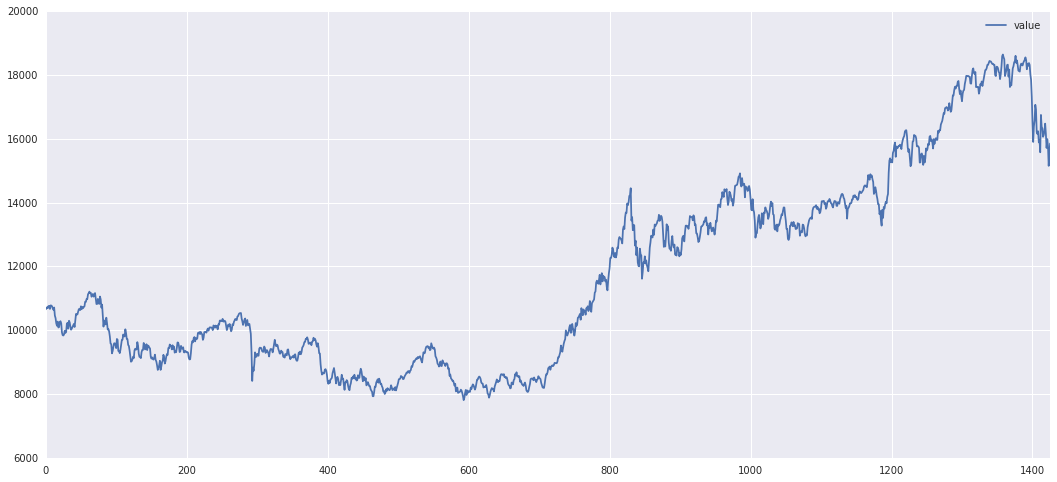

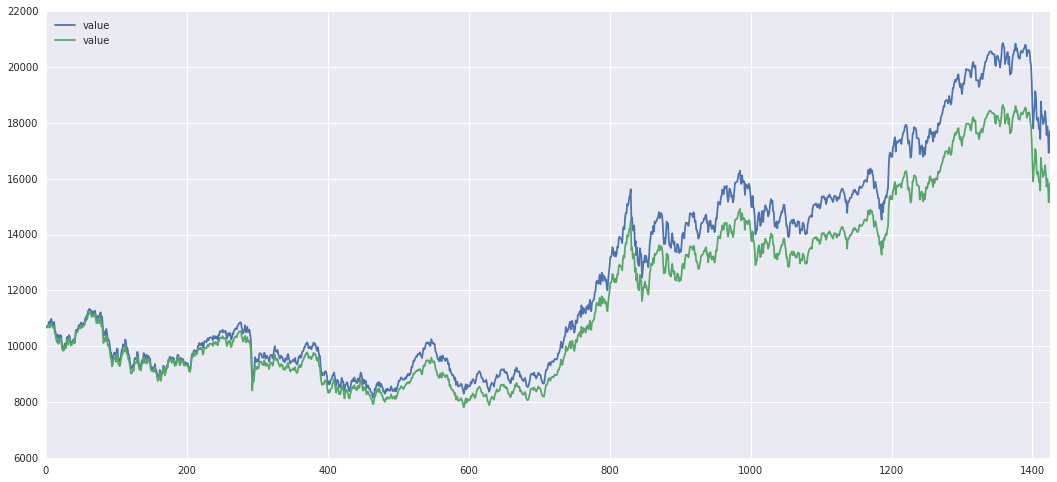

In [106]:
_ = pd.concat([state_greedy['value']],axis = 1).plot(figsize=(18,8))
_ = pd.concat([state_nikkei['value'], state_greedy['value']],axis = 1).plot(figsize=(18,8))

In [ ]:

def current_state_RL(shares_prev_step, previous_greedy_action, time_lag, time):
  state = {}
  state["price_vector"] = price_vector(time_lag,time)
  state["shares"] = new_shares(shares_prev_step, previous_greedy_action, time)
  state["value"] = portfolio_value(state["shares"], time)
  state["alpha"] = alpha_fun(state["shares"], time)
  state["cash"] = 0
  return state

state_RL = pd.DataFrame()

state_RL['price_nikkei'] = np.zeros(len_series)
state_RL['price_ftse'] = np.zeros(len_series)
state_RL['portfolio_shares_nikkei'] = np.zeros(len_series)
state_RL['portfolio_shares_ftse'] = np.zeros(len_series)
state_RL['value'] = np.zeros(len_series)
state_RL['alpha'] = np.ones(len_series)
state_RL['cash'] = np.zeros(len_series)

tau = .05

In [ ]:
previous_action = .1
shares_prev_step = [43,20]
print current_price_nikkei(10)
print current_price_ftse(10)
print portfolio_value(shares_prev_step,10)
current_state_RL(shares_prev_step, previous_action,2,11)

valid_actions(shares_prev_step,10)

In [ ]:
shares_0